In [6]:
import pygame
import numpy as np
import time
import matplotlib.pyplot as plt
import os
from matplotlib import style

In [7]:
class SquareMovement:
    def __init__(self, dist=15, timeout=30):
        self._now = -1
        self.now = -1
        self.dist = dist
        self.A = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                  3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
                  2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
                  1, 1, 1, 1, 1, 2]
        self.timeout = len(self.A)

    def __next__(self):
        self._now += 1
        if not self._now % self.dist:
            self.now = (self.now + 1) % 4

        if self._now >= self.timeout:
            return 0
        return self.A[self._now]

    def __repr__(self):
        return f"Square: {self.now}"


class Game:
    _count = 0

    def __init__(self, width=1.4e3, height=8e2, render=False, food_ammount=3,
                 view_len=4, time_out=10000):
        if render:
            pygame.init()
            width = int(width)
            height = int(height)
            self.screen = pygame.display.set_mode((width, height))

        self.render = render
        self.food_on_screen = food_ammount
        self.view_len = view_len
        self.time_out = time_out

        self.size = self.width, self.height = width, height
        self.score = 0
        self.direction = 1
        self.x = 0
        self.y = 0
        self.tail = [[self.x, self.y]]
        self.tail_len = 10
        self.food = []
        self.done = False
        self.current_time = 0

        self.square_move = SquareMovement()
        self.move_time = 1

        self.rect_size = 25
        self.speed_multiplier = 1
        self._reset()
        Game._count += 1

    def __del__(self):
        Game._count -= 1
        if Game._count < 1:
            pygame.quit()

    def _reset(self):
        self.score = 0
        self.direction = 1
        self.speed_multiplier = 1
        self.x = (self.width / 2) // self.rect_size * self.rect_size
        self.y = (self.height / 2) // self.rect_size * self.rect_size
        self.tail_len = 10
        self.tail = [[self.x, self.y]]
        self.food = []
        self.done = False
        self.current_time = 0
        self.food_refill(True, self.food_on_screen)

    def check_border(self, border=True):
        hit = False
        if border:  # Screen edge is border
            # Checking X values in proper range
            if self.x >= self.width:

                self.x = self.width - self.rect_size
                hit = True
            elif self.x < 0:
                self.x = 0
                hit = True
            # Checking Y values in proper range
            if self.y >= self.height:
                self.y = self.height - self.rect_size
                hit = True
            elif self.y < 0:
                self.y = 0
                hit = True  # if colision with wall return hit

        else:  # Screen edge is borderless (Continuous world)
            # Checking X values in proper range
            if self.x >= self.width:
                self.x = 0
            elif self.x < 0:
                self.x = self.width - self.rect_size
            # Checking Y values in proper range
            if self.y >= self.height:
                self.y = 0
            elif self.y < 0:
                self.y = self.height - self.rect_size
        return hit

    def check_collision_with_food(self, x, y):
        for pos in self.food:
            if [x, y] == pos:
                return True
        return False

    def check_collision_with_observationtacles(self, x, y):
        for pos in self.tail[1:-1]:
            if [x, y] == pos:
                # self.speed_multiplier = 0
                return True
        pass

    def check_collision_with_snake(self, x, y):
        for pos in self.tail:
            if [x, y] == pos:
                return True
        return False

    def display_score(self):
        my_font = pygame.font.SysFont('Comic Sans MS', 30)
        text_surface = my_font.render('Food-eaten = ' + str(self.score), False, (255, 255, 255))
        self.screen.blit(text_surface, (0, 0))

    def draw(self):
        if self.done:
            head_color = (255, 0, 0)
        else:
            head_color = (130, 255, 255)
        self.screen.fill((30, 30, 50))
        pygame.draw.rect(self.screen, (50, 150, 130),
                         (self.tail[0][0], self.tail[0][1], self.rect_size,
                          self.rect_size))  # last tail piece
        for tail in self.tail[1:]:
            pygame.draw.rect(self.screen, (35, 120, 50), (tail[0], tail[1], self.rect_size, self.rect_size))
        pygame.draw.rect(self.screen, head_color, (self.x, self.y, self.rect_size, self.rect_size))

        for food in self.food:
            pygame.draw.rect(self.screen, (0, 255, 0), (food[0], food[1], self.rect_size, self.rect_size))

        self.display_score()
        pygame.display.update()

        # surf = pygame.display.get_surface()
        # pygame.image.save(surf, f'image{index}.png')

    def eat_food(self):
        """

        Returns
        -------
        int: quantity of eaten food
        """
        out = 0
        for i, food in enumerate(self.food):
            if self.check_collision_with_snake(food[0], food[1]):
                self.food.pop(i)
                self.tail_len += 1
                self.score += 1
                out += 1
                self.place_food()
                break
        return out

    def food_refill(self, multi_food=False, n=1):
        while multi_food and len(self.food) < n \
                or len(self.food) < 1:
            self.place_food()

    def move_snake(self, new_direction, reverse=False):
        """
        Directions
          0       Up
        3   1     Left / Right
          2       Down
        """
        new_direction = int(new_direction)
        current_speed = self.speed_multiplier * self.rect_size
        # Turn only left or right
        if not ((self.direction in [0, 2] and new_direction in [0, 2])
                or (self.direction in [1, 3] and new_direction in [1, 3])):
            self.direction = new_direction

        if reverse:
            if self.direction == 0:
                self.y += current_speed
            elif self.direction == 1:
                self.x -= current_speed
            elif self.direction == 2:
                self.y -= current_speed
            else:
                self.x += current_speed
        else:
            if self.direction == 0:
                self.y -= current_speed
            elif self.direction == 1:
                self.x += current_speed
            elif self.direction == 2:
                self.y += current_speed
            else:
                self.x -= current_speed

    def observation_area(self):
        depth = self.view_len * 2 + 1  # in to direction + 1(center)
        view_area = np.zeros((depth, depth), dtype=int)
        for iy in range(depth):
            for ix in range(depth):
                x = int(self.x + (ix - self.view_len) * self.rect_size)
                y = int(self.y + (iy - self.view_len) * self.rect_size)  # Y is drawn from top to bot

                if x > self.width or x < 0 or \
                        y >= self.height or y < 0:
                    view_area[iy, ix] = 2
                    continue

                for f in self.food:
                    if [x, y] == f:
                        view_area[iy, ix] = 1
                        break

                for tail in self.tail:
                    if [x, y] == tail:
                        view_area[iy, ix] = 2
                        break

        return self.direction, view_area

    def observation(self):
        view_area = np.zeros((3, 3), dtype=int)
        for iy in range(3):
            for ix in range(3):
                x = int(self.x + (ix - 1) * self.rect_size)
                y = int(self.y + (iy - 1) * self.rect_size)

                if x > self.width or x < 0 or \
                        y >= self.height or y < 0:
                    view_area[iy, ix] = 1
                    continue

                for tail in self.tail:
                    if [x, y] == tail:
                        view_area[iy, ix] = 1
                        break

        if len(self.food) > 0:
            food = self.food[0]
        else:
            food = [2, 2]
            print(f"No Food info")
            return self.direction, food, view_area

        out = [food[0] - self.x, self.y - food[1]]
        return self.direction, out, view_area

    def place_food(self):
        while True:
            rx = np.random.rand() * (self.width - 1)
            ry = np.random.rand() * (self.height - 1)

            rx = round(rx // self.rect_size * self.rect_size)
            ry = round(ry // self.rect_size * self.rect_size)

            if self.check_collision_with_food(rx, ry):
                continue
            break
        self.food += [[rx, ry]]


    def reset(self):
        self._reset()
        return self.observation()

    def step(self, action):
        new_direction = (self.direction + (action - 1)) % 4
        if self.done:
            print("Run has ended")
        f_run = True
        self.current_time += 1
        self.food_refill(True, self.food_on_screen)

        if self.render:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    f_run = False
                    break

        self.move_snake(new_direction)
        hit1 = self.check_border()
        hit2 = self.check_collision_with_observationtacles(self.x, self.y)
        if hit1 or hit2:  # <<---- Collision, Disable loop
            f_run = False
            # if hit2:
            #     self.move_snake(reverse=True)
            self.speed_multiplier = 0
            _color = (255, 0, 0)
        else:
            _color = (130, 255, 255)

        self.update_tail()
        reward = self.eat_food() * 50 - 1  # Eaten food is worth 5
        observation = self.observation()

        if not f_run:  # Devalue reward
            self.done = True
            reward = -100

        if self.current_time >= self.time_out:
            f_run = False
            print(f"Timeout! score: {self.score}")
            self.done = True

        return f_run, reward, observation

    def update_tail(self):
        if self.tail[-1] != [self.x, self.y]:
            self.tail += [[self.x, self.y]]

        if len(self.tail) > (self.tail_len + 1):
            self.tail = self.tail[-self.tail_len - 1:]
            # self.tail.pop(0)


def get_discrete_vals(q_table, observation):
    
    index = discrete_state_index(observation)
    q_values = q_table[tuple(index)]
    return q_values


def discrete_state_index(observation):

    direction, food_relative, view_area = observation
    discrete_index = 0

    f_x = int(0 if not food_relative[0] else 1 * np.sign(food_relative[0])) + 1  # Select food relative x
    f_y = int(0 if not food_relative[1] else 1 * np.sign(food_relative[1])) + 1  # Select food relative y
    for i, field in enumerate(view_area.ravel()):
        if not field:  # Ignore 0=Path
            continue

        add = (FIELD_STATES ** i) * field
        discrete_index += add

    return direction, f_x, f_y, discrete_index



In [8]:
def main(EPISODES,SHOW_EVERY,LEARNING_RATE,DISCOUNT):
    global FIELD_STATES
    "Environment"
    ACTIONS = 3  # Turn left, right or none
    MOVE_DIRECTIONS = 4  # state movement directions
    FIELD_STATES = 2
    VIEW_AREA = 9
    FOOD_SIZE = [3, 3]

    "Exploration"
    eps = 0.5
    EPS_OFFSET = 0
    EPS_START_DECAYING = 0
    EPS_DECAY_AT = EPISODES // 2
    eps_iterator = iter(np.linspace(eps, 0, EPS_DECAY_AT - EPS_START_DECAYING))

    "Q-Table initialization"
    size = [MOVE_DIRECTIONS] + FOOD_SIZE + [FIELD_STATES ** VIEW_AREA] + [ACTIONS]
    try:
        q_table = np.load('last_qtable.npy', allow_pickle=True)
    except FileNotFoundError:
        print(f"Creating new qtable!")
        q_table = np.random.uniform(-1, 0, size=size)

    try:
        stats = np.load('last_stats.npy', allow_pickle=True).item()
        episode_offset = stats['episode'][-1] + 1
    except FileNotFoundError:
        stats = {
            "episode": [],
            "eps": [],
            "score": [],
            "food_eaten": []
        }
        episode_offset = 0

    for episode in range(0 + episode_offset, EPISODES + episode_offset):
        # Show every and show last
        if not episode % SHOW_EVERY or episode >= EPISODES + episode_offset - 1:
            render = True
        else:
            render = False

        game = None
        game = Game(food_ammount=1, render=render)
        valid = True
        observation = Game().reset()
        score = 0

        if EPS_DECAY_AT + episode_offset > episode >= EPS_START_DECAYING + episode_offset:
            eps = next(eps_iterator) + EPS_OFFSET
        else:
            eps = EPS_OFFSET
        while valid:
            old_observation = observation
            current_q_values = get_discrete_vals(q_table, old_observation)

            if eps > np.random.random():
                action = np.random.randint(0, ACTIONS)
            else:
                action = np.argmax(current_q_values)

            old_q = current_q_values[action]

            valid, reward, observation = game.step(action=action)
            max_future_q = max(get_discrete_vals(q_table, observation))
            new_q = (1 - LEARNING_RATE) * old_q \
                + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state_index(old_observation) + (action,)] = new_q

            if render:
                game.draw()
                time.sleep(0.03)
            score += reward

        stats['episode'].append(episode)
        stats['eps'].append(eps)
        stats['score'].append(score)
        stats['food_eaten'].append(game.score)

        if game.score > 10:
            print(f"Ep[{episode:^7}], food_eaten:{game.score:>4}, Eps: {eps:>1.3f}, reward:{score:>6}")

    # Saving outputs
    os.makedirs('graphs', exist_ok=True)

    np.save('last_qtable.npy', q_table)
    np.save('last_stats.npy', stats)

    pygame.quit()

    style.use('ggplot')
    plt.scatter(
            stats['episode'][episode_offset:],
            stats['food_eaten'][episode_offset:],
            alpha=0.13, marker='s', edgecolors='m', label="Comido"
    )
    plt.legend(loc=3)
    plt.savefig('Save.png')
    plt.show()




In [ ]:
main(10000,1000,0.25,0.85)

Ep[ 13711 ], food_eaten:  11, Eps: 0.129, reward:    59
Ep[ 13880 ], food_eaten:  13, Eps: 0.112, reward:   153
Ep[ 13965 ], food_eaten:  11, Eps: 0.103, reward:  -184
Ep[ 14060 ], food_eaten:  12, Eps: 0.094, reward:   -19
Ep[ 14066 ], food_eaten:  11, Eps: 0.093, reward:     6
Ep[ 14072 ], food_eaten:  13, Eps: 0.093, reward:  -372
Ep[ 14235 ], food_eaten:  14, Eps: 0.076, reward:    92
Ep[ 14405 ], food_eaten:  11, Eps: 0.059, reward:   -26
Ep[ 14444 ], food_eaten:  13, Eps: 0.056, reward:    49
Ep[ 14458 ], food_eaten:  12, Eps: 0.054, reward:   -66
Ep[ 14460 ], food_eaten:  12, Eps: 0.054, reward:  -184
Ep[ 14477 ], food_eaten:  25, Eps: 0.052, reward:     0
Ep[ 14487 ], food_eaten:  12, Eps: 0.051, reward:  -111
Ep[ 14500 ], food_eaten:  18, Eps: 0.050, reward:    72
Ep[ 14506 ], food_eaten:  23, Eps: 0.049, reward:   199
Ep[ 14513 ], food_eaten:  18, Eps: 0.049, reward:    97
Ep[ 14515 ], food_eaten:  13, Eps: 0.048, reward:    86
Ep[ 14522 ], food_eaten:  15, Eps: 0.048, reward

Ep[ 14896 ], food_eaten:  63, Eps: 0.010, reward:   402
Ep[ 14898 ], food_eaten:  23, Eps: 0.010, reward:   311
Ep[ 14899 ], food_eaten:  34, Eps: 0.010, reward:   393
Ep[ 14900 ], food_eaten:  14, Eps: 0.010, reward:    71
Ep[ 14901 ], food_eaten:  45, Eps: 0.010, reward:   594
Ep[ 14902 ], food_eaten:  33, Eps: 0.010, reward:   325
Ep[ 14903 ], food_eaten:  11, Eps: 0.010, reward:    65
Ep[ 14904 ], food_eaten:  24, Eps: 0.010, reward:   -41
Ep[ 14905 ], food_eaten:  50, Eps: 0.009, reward:   622
Ep[ 14908 ], food_eaten:  11, Eps: 0.009, reward:  -128
Ep[ 14912 ], food_eaten:  16, Eps: 0.009, reward:  -423
Ep[ 14914 ], food_eaten:  13, Eps: 0.009, reward:  -176
Ep[ 14915 ], food_eaten:  44, Eps: 0.008, reward:   300
Ep[ 14916 ], food_eaten:  34, Eps: 0.008, reward:   192
Ep[ 14917 ], food_eaten:  30, Eps: 0.008, reward:   359
Ep[ 14918 ], food_eaten:  29, Eps: 0.008, reward:   183
Ep[ 14919 ], food_eaten:  27, Eps: 0.008, reward:    99
Ep[ 14920 ], food_eaten:  48, Eps: 0.008, reward

Ep[ 15069 ], food_eaten:  66, Eps: 0.000, reward:   292
Ep[ 15070 ], food_eaten:  61, Eps: 0.000, reward:   320
Ep[ 15071 ], food_eaten:  66, Eps: 0.000, reward:   480
Ep[ 15072 ], food_eaten:  23, Eps: 0.000, reward:  -139
Ep[ 15073 ], food_eaten:  13, Eps: 0.000, reward:  -106
Ep[ 15074 ], food_eaten:  33, Eps: 0.000, reward:   265
Ep[ 15075 ], food_eaten:  15, Eps: 0.000, reward:  -245
Ep[ 15076 ], food_eaten:  37, Eps: 0.000, reward:   -89
Ep[ 15077 ], food_eaten:  21, Eps: 0.000, reward:   295
Ep[ 15078 ], food_eaten:  25, Eps: 0.000, reward:    41
Ep[ 15079 ], food_eaten:  51, Eps: 0.000, reward:   253
Ep[ 15080 ], food_eaten:  14, Eps: 0.000, reward:    45
Ep[ 15081 ], food_eaten:  42, Eps: 0.000, reward:    81
Ep[ 15082 ], food_eaten:  64, Eps: 0.000, reward:   355
Ep[ 15083 ], food_eaten:  45, Eps: 0.000, reward:   193
Ep[ 15084 ], food_eaten:  53, Eps: 0.000, reward:   199
Ep[ 15085 ], food_eaten:  43, Eps: 0.000, reward:   354
Ep[ 15086 ], food_eaten:  14, Eps: 0.000, reward

Ep[ 15227 ], food_eaten:  51, Eps: 0.000, reward:   111
Ep[ 15228 ], food_eaten:  20, Eps: 0.000, reward:    27
Ep[ 15229 ], food_eaten:  20, Eps: 0.000, reward:   102
Ep[ 15230 ], food_eaten:  23, Eps: 0.000, reward:   292
Ep[ 15231 ], food_eaten:  48, Eps: 0.000, reward:   302
Ep[ 15232 ], food_eaten:  42, Eps: 0.000, reward:   307
Ep[ 15233 ], food_eaten:  21, Eps: 0.000, reward:    74
Ep[ 15234 ], food_eaten:  42, Eps: 0.000, reward:   376
Ep[ 15235 ], food_eaten:  32, Eps: 0.000, reward:   300
Ep[ 15236 ], food_eaten:  21, Eps: 0.000, reward:   182
Ep[ 15237 ], food_eaten:  42, Eps: 0.000, reward:   444
Ep[ 15238 ], food_eaten:  59, Eps: 0.000, reward:   211
Ep[ 15239 ], food_eaten:  14, Eps: 0.000, reward:   -50
Ep[ 15241 ], food_eaten:  26, Eps: 0.000, reward:   -58
Ep[ 15242 ], food_eaten:  38, Eps: 0.000, reward:   330
Ep[ 15243 ], food_eaten:  23, Eps: 0.000, reward:    35
Ep[ 15244 ], food_eaten:  29, Eps: 0.000, reward:  -406
Ep[ 15245 ], food_eaten:  28, Eps: 0.000, reward

Ep[ 15387 ], food_eaten:  50, Eps: 0.000, reward:   239
Ep[ 15388 ], food_eaten:  37, Eps: 0.000, reward:   111
Ep[ 15389 ], food_eaten:  31, Eps: 0.000, reward:    54
Ep[ 15391 ], food_eaten:  47, Eps: 0.000, reward:   -89
Ep[ 15392 ], food_eaten:  18, Eps: 0.000, reward:    61
Ep[ 15393 ], food_eaten:  14, Eps: 0.000, reward:    54
Ep[ 15394 ], food_eaten:  52, Eps: 0.000, reward:   190
Ep[ 15395 ], food_eaten:  42, Eps: 0.000, reward:   130
Ep[ 15396 ], food_eaten:  41, Eps: 0.000, reward:   300
Ep[ 15397 ], food_eaten:  27, Eps: 0.000, reward:    65
Ep[ 15398 ], food_eaten:  37, Eps: 0.000, reward:  -227
Ep[ 15399 ], food_eaten:  62, Eps: 0.000, reward:    47
Ep[ 15400 ], food_eaten:  43, Eps: 0.000, reward:   336
Ep[ 15401 ], food_eaten:  54, Eps: 0.000, reward:   242
Ep[ 15402 ], food_eaten:  45, Eps: 0.000, reward:   117
Ep[ 15403 ], food_eaten:  35, Eps: 0.000, reward:   262
Ep[ 15405 ], food_eaten:  43, Eps: 0.000, reward:   491
Ep[ 15406 ], food_eaten:  13, Eps: 0.000, reward

Ep[ 15545 ], food_eaten:  43, Eps: 0.000, reward:    14
Ep[ 15546 ], food_eaten:  27, Eps: 0.000, reward:    64
Ep[ 15547 ], food_eaten:  57, Eps: 0.000, reward:   320
Ep[ 15548 ], food_eaten:  20, Eps: 0.000, reward:    60
Ep[ 15549 ], food_eaten:  67, Eps: 0.000, reward:  -170
Ep[ 15550 ], food_eaten:  35, Eps: 0.000, reward:    51
Ep[ 15551 ], food_eaten:  38, Eps: 0.000, reward:   402
Ep[ 15552 ], food_eaten:  35, Eps: 0.000, reward:   -33
Ep[ 15553 ], food_eaten:  33, Eps: 0.000, reward:   314
Ep[ 15554 ], food_eaten:  48, Eps: 0.000, reward:   215
Ep[ 15555 ], food_eaten:  45, Eps: 0.000, reward:   118
Ep[ 15556 ], food_eaten:  50, Eps: 0.000, reward:   -34
Ep[ 15557 ], food_eaten:  18, Eps: 0.000, reward:  -213
Ep[ 15558 ], food_eaten:  25, Eps: 0.000, reward:   -58
Ep[ 15559 ], food_eaten:  54, Eps: 0.000, reward:   266
Ep[ 15560 ], food_eaten:  51, Eps: 0.000, reward:   251
Ep[ 15561 ], food_eaten:  38, Eps: 0.000, reward:     1
Ep[ 15562 ], food_eaten:  79, Eps: 0.000, reward

Ep[ 15702 ], food_eaten:  52, Eps: 0.000, reward:   481
Ep[ 15703 ], food_eaten:  27, Eps: 0.000, reward:   234
Ep[ 15704 ], food_eaten:  32, Eps: 0.000, reward:   259
Ep[ 15705 ], food_eaten:  48, Eps: 0.000, reward:   426
Ep[ 15707 ], food_eaten:  37, Eps: 0.000, reward:   176
Ep[ 15708 ], food_eaten:  55, Eps: 0.000, reward:   682
Ep[ 15709 ], food_eaten:  16, Eps: 0.000, reward:    34
Ep[ 15710 ], food_eaten:  66, Eps: 0.000, reward:   381
Ep[ 15712 ], food_eaten:  28, Eps: 0.000, reward:   220
Ep[ 15713 ], food_eaten:  41, Eps: 0.000, reward:   333
Ep[ 15714 ], food_eaten:  41, Eps: 0.000, reward:  -111
Ep[ 15715 ], food_eaten:  17, Eps: 0.000, reward:   -61
Ep[ 15716 ], food_eaten:  19, Eps: 0.000, reward: -2273
Ep[ 15718 ], food_eaten:  40, Eps: 0.000, reward:  -474
Ep[ 15719 ], food_eaten:  36, Eps: 0.000, reward:  -213
Ep[ 15720 ], food_eaten:  17, Eps: 0.000, reward:  -193
Ep[ 15721 ], food_eaten:  54, Eps: 0.000, reward:  -400
Ep[ 15722 ], food_eaten:  64, Eps: 0.000, reward

Ep[ 15859 ], food_eaten:  43, Eps: 0.000, reward:   -15
Ep[ 15860 ], food_eaten:  55, Eps: 0.000, reward:    11
Ep[ 15861 ], food_eaten:  33, Eps: 0.000, reward:   220
Ep[ 15862 ], food_eaten:  62, Eps: 0.000, reward:    -4
Ep[ 15863 ], food_eaten:  46, Eps: 0.000, reward:  -117
Ep[ 15864 ], food_eaten:  45, Eps: 0.000, reward:  -199
Ep[ 15865 ], food_eaten:  68, Eps: 0.000, reward:   120
Ep[ 15866 ], food_eaten:  31, Eps: 0.000, reward:   -50
Ep[ 15867 ], food_eaten:  28, Eps: 0.000, reward:    -9
Ep[ 15868 ], food_eaten:  55, Eps: 0.000, reward:   391
Ep[ 15869 ], food_eaten:  30, Eps: 0.000, reward:  -292
Ep[ 15870 ], food_eaten:  78, Eps: 0.000, reward:   545
Ep[ 15871 ], food_eaten:  66, Eps: 0.000, reward:  -231
Ep[ 15872 ], food_eaten:  33, Eps: 0.000, reward:  -146
Ep[ 15873 ], food_eaten:  49, Eps: 0.000, reward:   333
Ep[ 15874 ], food_eaten:  76, Eps: 0.000, reward:   357
Ep[ 15875 ], food_eaten:  52, Eps: 0.000, reward:    43
Ep[ 15876 ], food_eaten:  56, Eps: 0.000, reward

Creating new qtable!
Ep[ 4132  ], food_eaten:  13, Eps: 0.087, reward:    14
Ep[ 4133  ], food_eaten:  12, Eps: 0.087, reward:   -47
Ep[ 4155  ], food_eaten:  12, Eps: 0.084, reward:  -195
Ep[ 4160  ], food_eaten:  11, Eps: 0.084, reward:  -158
Ep[ 4201  ], food_eaten:  15, Eps: 0.080, reward:    58
Ep[ 4347  ], food_eaten:  13, Eps: 0.065, reward:   -96
Ep[ 4454  ], food_eaten:  11, Eps: 0.055, reward:   114
Ep[ 4456  ], food_eaten:  20, Eps: 0.054, reward:   -78
Ep[ 4463  ], food_eaten:  12, Eps: 0.054, reward:  -117
Ep[ 4494  ], food_eaten:  14, Eps: 0.051, reward:    13
Ep[ 4499  ], food_eaten:  16, Eps: 0.050, reward:    23
Ep[ 4517  ], food_eaten:  11, Eps: 0.048, reward:  -188
Ep[ 4584  ], food_eaten:  20, Eps: 0.042, reward:   155
Ep[ 4623  ], food_eaten:  13, Eps: 0.038, reward:  -109
Ep[ 4699  ], food_eaten:  14, Eps: 0.030, reward:    13
Ep[ 4709  ], food_eaten:  13, Eps: 0.029, reward:  -121
Ep[ 4713  ], food_eaten:  12, Eps: 0.029, reward:  -197
Ep[ 4714  ], food_eaten:  1

Ep[ 5070  ], food_eaten:  27, Eps: 0.000, reward:   115
Ep[ 5071  ], food_eaten:  32, Eps: 0.000, reward:   181
Ep[ 5073  ], food_eaten:  19, Eps: 0.000, reward:   171
Ep[ 5074  ], food_eaten:  13, Eps: 0.000, reward:   102
Ep[ 5076  ], food_eaten:  19, Eps: 0.000, reward:  -118
Ep[ 5077  ], food_eaten:  30, Eps: 0.000, reward:   434
Ep[ 5078  ], food_eaten:  21, Eps: 0.000, reward:    -2
Ep[ 5079  ], food_eaten:  17, Eps: 0.000, reward:   217
Ep[ 5080  ], food_eaten:  23, Eps: 0.000, reward:   144
Ep[ 5081  ], food_eaten:  31, Eps: 0.000, reward:   416
Ep[ 5082  ], food_eaten:  28, Eps: 0.000, reward:   452
Ep[ 5084  ], food_eaten:  16, Eps: 0.000, reward:   147
Ep[ 5086  ], food_eaten:  38, Eps: 0.000, reward:   368
Ep[ 5087  ], food_eaten:  16, Eps: 0.000, reward:   101
Ep[ 5088  ], food_eaten:  28, Eps: 0.000, reward:   287
Ep[ 5090  ], food_eaten:  41, Eps: 0.000, reward:    56
Ep[ 5091  ], food_eaten:  38, Eps: 0.000, reward:   231
Ep[ 5094  ], food_eaten:  11, Eps: 0.000, reward

Ep[ 5269  ], food_eaten:  31, Eps: 0.000, reward:   372
Ep[ 5270  ], food_eaten:  57, Eps: 0.000, reward:   651
Ep[ 5271  ], food_eaten:  22, Eps: 0.000, reward:   160
Ep[ 5272  ], food_eaten:  23, Eps: 0.000, reward:   258
Ep[ 5273  ], food_eaten:  16, Eps: 0.000, reward:   188
Ep[ 5274  ], food_eaten:  41, Eps: 0.000, reward:   665
Ep[ 5275  ], food_eaten:  37, Eps: 0.000, reward:   369
Ep[ 5276  ], food_eaten:  33, Eps: 0.000, reward:   304
Ep[ 5277  ], food_eaten:  37, Eps: 0.000, reward:   286
Ep[ 5278  ], food_eaten:  11, Eps: 0.000, reward:   138
Ep[ 5279  ], food_eaten:  15, Eps: 0.000, reward:   105
Ep[ 5281  ], food_eaten:  16, Eps: 0.000, reward:   115
Ep[ 5282  ], food_eaten:  52, Eps: 0.000, reward:   624
Ep[ 5283  ], food_eaten:  53, Eps: 0.000, reward:   661
Ep[ 5285  ], food_eaten:  54, Eps: 0.000, reward:   370
Ep[ 5287  ], food_eaten:  30, Eps: 0.000, reward:   250
Ep[ 5288  ], food_eaten:  16, Eps: 0.000, reward:   178
Ep[ 5289  ], food_eaten:  30, Eps: 0.000, reward

Ep[ 5451  ], food_eaten:  30, Eps: 0.000, reward:   255
Ep[ 5452  ], food_eaten:  26, Eps: 0.000, reward:   235
Ep[ 5454  ], food_eaten:  18, Eps: 0.000, reward:   170
Ep[ 5455  ], food_eaten:  41, Eps: 0.000, reward:   232
Ep[ 5457  ], food_eaten:  39, Eps: 0.000, reward:   392
Ep[ 5459  ], food_eaten:  23, Eps: 0.000, reward:   358
Ep[ 5460  ], food_eaten:  21, Eps: 0.000, reward:   297
Ep[ 5461  ], food_eaten:  52, Eps: 0.000, reward:   324
Ep[ 5462  ], food_eaten:  38, Eps: 0.000, reward:   335
Ep[ 5463  ], food_eaten:  12, Eps: 0.000, reward:    60
Ep[ 5464  ], food_eaten:  36, Eps: 0.000, reward:   258
Ep[ 5465  ], food_eaten:  14, Eps: 0.000, reward:    80
Ep[ 5466  ], food_eaten:  57, Eps: 0.000, reward:   523
Ep[ 5467  ], food_eaten:  23, Eps: 0.000, reward:   103
Ep[ 5468  ], food_eaten:  12, Eps: 0.000, reward:    31
Ep[ 5469  ], food_eaten:  42, Eps: 0.000, reward:   461
Ep[ 5470  ], food_eaten:  54, Eps: 0.000, reward:   401
Ep[ 5471  ], food_eaten:  28, Eps: 0.000, reward

Ep[ 5623  ], food_eaten:  33, Eps: 0.000, reward:   134
Ep[ 5624  ], food_eaten:  39, Eps: 0.000, reward:   270
Ep[ 5625  ], food_eaten:  40, Eps: 0.000, reward:   344
Ep[ 5626  ], food_eaten:  40, Eps: 0.000, reward:   366
Ep[ 5627  ], food_eaten:  39, Eps: 0.000, reward:   362
Ep[ 5628  ], food_eaten:  21, Eps: 0.000, reward:   290
Ep[ 5629  ], food_eaten:  18, Eps: 0.000, reward:   339
Ep[ 5630  ], food_eaten:  29, Eps: 0.000, reward:   467
Ep[ 5631  ], food_eaten:  18, Eps: 0.000, reward:   143
Ep[ 5632  ], food_eaten:  18, Eps: 0.000, reward:   272
Ep[ 5633  ], food_eaten:  25, Eps: 0.000, reward:   129
Ep[ 5634  ], food_eaten:  11, Eps: 0.000, reward:    65
Ep[ 5635  ], food_eaten:  14, Eps: 0.000, reward:    22
Ep[ 5636  ], food_eaten:  28, Eps: 0.000, reward:   306
Ep[ 5637  ], food_eaten:  22, Eps: 0.000, reward:   302
Ep[ 5639  ], food_eaten:  11, Eps: 0.000, reward:   -27
Ep[ 5640  ], food_eaten:  37, Eps: 0.000, reward:   575
Ep[ 5642  ], food_eaten:  15, Eps: 0.000, reward

Ep[ 5791  ], food_eaten:  39, Eps: 0.000, reward:   627
Ep[ 5795  ], food_eaten:  33, Eps: 0.000, reward:   402
Ep[ 5796  ], food_eaten:  15, Eps: 0.000, reward:   136
Ep[ 5797  ], food_eaten:  15, Eps: 0.000, reward:   263
Ep[ 5798  ], food_eaten:  23, Eps: 0.000, reward:   202
Ep[ 5799  ], food_eaten:  35, Eps: 0.000, reward:   374
Ep[ 5800  ], food_eaten:  12, Eps: 0.000, reward:   -68
Ep[ 5801  ], food_eaten:  24, Eps: 0.000, reward:   287
Ep[ 5802  ], food_eaten:  12, Eps: 0.000, reward:   142
Ep[ 5803  ], food_eaten:  29, Eps: 0.000, reward:   371
Ep[ 5804  ], food_eaten:  24, Eps: 0.000, reward:   258
Ep[ 5805  ], food_eaten:  42, Eps: 0.000, reward:   369
Ep[ 5806  ], food_eaten:  35, Eps: 0.000, reward:   376
Ep[ 5807  ], food_eaten:  54, Eps: 0.000, reward:   647
Ep[ 5808  ], food_eaten:  19, Eps: 0.000, reward:   269
Ep[ 5810  ], food_eaten:  37, Eps: 0.000, reward:   487
Ep[ 5813  ], food_eaten:  36, Eps: 0.000, reward:   496
Ep[ 5814  ], food_eaten:  55, Eps: 0.000, reward

Ep[ 5966  ], food_eaten:  67, Eps: 0.000, reward:   533
Ep[ 5967  ], food_eaten:  34, Eps: 0.000, reward:   458
Ep[ 5968  ], food_eaten:  41, Eps: 0.000, reward:   539
Ep[ 5969  ], food_eaten:  18, Eps: 0.000, reward:   252
Ep[ 5970  ], food_eaten:  46, Eps: 0.000, reward:   717
Ep[ 5971  ], food_eaten:  44, Eps: 0.000, reward:   500
Ep[ 5972  ], food_eaten:  22, Eps: 0.000, reward:    79
Ep[ 5973  ], food_eaten:  14, Eps: 0.000, reward:   140
Ep[ 5975  ], food_eaten:  14, Eps: 0.000, reward:    94
Ep[ 5977  ], food_eaten:  31, Eps: 0.000, reward:   329
Ep[ 5978  ], food_eaten:  34, Eps: 0.000, reward:   207
Ep[ 5979  ], food_eaten:  31, Eps: 0.000, reward:   203
Ep[ 5980  ], food_eaten:  24, Eps: 0.000, reward:   259
Ep[ 5981  ], food_eaten:  11, Eps: 0.000, reward:   -42
Ep[ 5982  ], food_eaten:  12, Eps: 0.000, reward:    14
Ep[ 5983  ], food_eaten:  28, Eps: 0.000, reward:   317
Ep[ 5984  ], food_eaten:  29, Eps: 0.000, reward:   141
Ep[ 5985  ], food_eaten:  13, Eps: 0.000, reward

Ep[ 6294  ], food_eaten:  26, Eps: 0.000, reward:   406
Ep[ 6295  ], food_eaten:  38, Eps: 0.000, reward:   213
Ep[ 6296  ], food_eaten:  41, Eps: 0.000, reward:   328
Ep[ 6297  ], food_eaten:  15, Eps: 0.000, reward:    47
Ep[ 6298  ], food_eaten:  36, Eps: 0.000, reward:  -295
Ep[ 6299  ], food_eaten:  20, Eps: 0.000, reward:  -150
Ep[ 6301  ], food_eaten:  19, Eps: 0.000, reward:  -103
Ep[ 6306  ], food_eaten:  15, Eps: 0.000, reward:  -368
Ep[ 6307  ], food_eaten:  35, Eps: 0.000, reward:  -128
Ep[ 6308  ], food_eaten:  13, Eps: 0.000, reward:   -74
Ep[ 6309  ], food_eaten:  19, Eps: 0.000, reward:   -33
Ep[ 6310  ], food_eaten:  14, Eps: 0.000, reward:   139
Ep[ 6311  ], food_eaten:  31, Eps: 0.000, reward:    91
Ep[ 6313  ], food_eaten:  11, Eps: 0.000, reward:    64
Ep[ 6314  ], food_eaten:  16, Eps: 0.000, reward:  -122
Ep[ 6317  ], food_eaten:  15, Eps: 0.000, reward:    60
Ep[ 6318  ], food_eaten:  20, Eps: 0.000, reward:   253
Ep[ 6319  ], food_eaten:  15, Eps: 0.000, reward

Ep[ 6496  ], food_eaten:  44, Eps: 0.000, reward:   670
Ep[ 6497  ], food_eaten:  47, Eps: 0.000, reward:   635
Ep[ 6498  ], food_eaten:  34, Eps: 0.000, reward:   548
Ep[ 6499  ], food_eaten:  11, Eps: 0.000, reward:   152
Ep[ 6500  ], food_eaten:  53, Eps: 0.000, reward:   672
Ep[ 6501  ], food_eaten:  11, Eps: 0.000, reward:    24
Ep[ 6502  ], food_eaten:  31, Eps: 0.000, reward:   366
Ep[ 6503  ], food_eaten:  29, Eps: 0.000, reward:   398
Ep[ 6505  ], food_eaten:  25, Eps: 0.000, reward:   276
Ep[ 6506  ], food_eaten:  21, Eps: 0.000, reward:   240
Ep[ 6507  ], food_eaten:  12, Eps: 0.000, reward:    31
Ep[ 6508  ], food_eaten:  55, Eps: 0.000, reward:   541
Ep[ 6510  ], food_eaten:  30, Eps: 0.000, reward:   284
Ep[ 6511  ], food_eaten:  63, Eps: 0.000, reward:  1065
Ep[ 6512  ], food_eaten:  25, Eps: 0.000, reward:   293
Ep[ 6513  ], food_eaten:  39, Eps: 0.000, reward:   622
Ep[ 6514  ], food_eaten:  68, Eps: 0.000, reward:  1039
Ep[ 6515  ], food_eaten:  39, Eps: 0.000, reward

Ep[ 6660  ], food_eaten:  11, Eps: 0.000, reward:    73
Ep[ 6661  ], food_eaten:  15, Eps: 0.000, reward:    46
Ep[ 6662  ], food_eaten:  18, Eps: 0.000, reward:   226
Ep[ 6663  ], food_eaten:  39, Eps: 0.000, reward:   429
Ep[ 6664  ], food_eaten:  19, Eps: 0.000, reward:   344
Ep[ 6665  ], food_eaten:  24, Eps: 0.000, reward:   388
Ep[ 6666  ], food_eaten:  48, Eps: 0.000, reward:   -81
Ep[ 6668  ], food_eaten:  13, Eps: 0.000, reward:    52
Ep[ 6671  ], food_eaten:  23, Eps: 0.000, reward:   110
Ep[ 6672  ], food_eaten:  34, Eps: 0.000, reward:   284
Ep[ 6673  ], food_eaten:  11, Eps: 0.000, reward:    94
Ep[ 6674  ], food_eaten:  22, Eps: 0.000, reward:    44
Ep[ 6675  ], food_eaten:  14, Eps: 0.000, reward:  -138
Ep[ 6677  ], food_eaten:  41, Eps: 0.000, reward:    16
Ep[ 6678  ], food_eaten:  35, Eps: 0.000, reward:   -58
Ep[ 6680  ], food_eaten:  25, Eps: 0.000, reward:  -332
Ep[ 6684  ], food_eaten:  24, Eps: 0.000, reward:  -456
Ep[ 6685  ], food_eaten:  21, Eps: 0.000, reward

Ep[ 6842  ], food_eaten:  46, Eps: 0.000, reward:   242
Ep[ 6844  ], food_eaten:  47, Eps: 0.000, reward:   391
Ep[ 6845  ], food_eaten:  30, Eps: 0.000, reward:   -49
Ep[ 6846  ], food_eaten:  28, Eps: 0.000, reward:    31
Ep[ 6847  ], food_eaten:  21, Eps: 0.000, reward:   162
Ep[ 6848  ], food_eaten:  46, Eps: 0.000, reward:   273
Ep[ 6849  ], food_eaten:  23, Eps: 0.000, reward:   125
Ep[ 6850  ], food_eaten:  32, Eps: 0.000, reward:   131
Ep[ 6851  ], food_eaten:  41, Eps: 0.000, reward:   256
Ep[ 6853  ], food_eaten:  45, Eps: 0.000, reward:    49
Ep[ 6854  ], food_eaten:  24, Eps: 0.000, reward:   111
Ep[ 6855  ], food_eaten:  39, Eps: 0.000, reward:   102
Ep[ 6856  ], food_eaten:  34, Eps: 0.000, reward:   293
Ep[ 6857  ], food_eaten:  39, Eps: 0.000, reward:    53
Ep[ 6858  ], food_eaten:  32, Eps: 0.000, reward:    47
Ep[ 6859  ], food_eaten:  18, Eps: 0.000, reward:    78
Ep[ 6860  ], food_eaten:  29, Eps: 0.000, reward:   239
Ep[ 6861  ], food_eaten:  34, Eps: 0.000, reward

Ep[ 7012  ], food_eaten:  38, Eps: 0.000, reward:   112
Ep[ 7013  ], food_eaten:  26, Eps: 0.000, reward:    86
Ep[ 7014  ], food_eaten:  18, Eps: 0.000, reward:  -105
Ep[ 7015  ], food_eaten:  44, Eps: 0.000, reward:     3
Ep[ 7016  ], food_eaten:  30, Eps: 0.000, reward:    18
Ep[ 7017  ], food_eaten:  25, Eps: 0.000, reward:  -213
Ep[ 7018  ], food_eaten:  27, Eps: 0.000, reward:    58
Ep[ 7019  ], food_eaten:  26, Eps: 0.000, reward:   -96
Ep[ 7020  ], food_eaten:  18, Eps: 0.000, reward:    73
Ep[ 7021  ], food_eaten:  20, Eps: 0.000, reward:   167
Ep[ 7022  ], food_eaten:  38, Eps: 0.000, reward:    45
Ep[ 7023  ], food_eaten:  17, Eps: 0.000, reward:   -71
Ep[ 7024  ], food_eaten:  38, Eps: 0.000, reward:   104
Ep[ 7025  ], food_eaten:  29, Eps: 0.000, reward:  -184
Ep[ 7026  ], food_eaten:  43, Eps: 0.000, reward:  -389
Ep[ 7027  ], food_eaten:  21, Eps: 0.000, reward:  -160
Ep[ 7028  ], food_eaten:  35, Eps: 0.000, reward:   307
Ep[ 7029  ], food_eaten:  14, Eps: 0.000, reward

Ep[ 7340  ], food_eaten:  57, Eps: 0.000, reward:    56
Ep[ 7341  ], food_eaten:  30, Eps: 0.000, reward:   130
Ep[ 7342  ], food_eaten:  32, Eps: 0.000, reward:   218
Ep[ 7343  ], food_eaten:  61, Eps: 0.000, reward:   351
Ep[ 7344  ], food_eaten:  40, Eps: 0.000, reward:   290
Ep[ 7345  ], food_eaten:  65, Eps: 0.000, reward:    76
Ep[ 7346  ], food_eaten:  36, Eps: 0.000, reward:   239
Ep[ 7347  ], food_eaten:  44, Eps: 0.000, reward:   423
Ep[ 7348  ], food_eaten:  55, Eps: 0.000, reward:    64
Ep[ 7349  ], food_eaten:  59, Eps: 0.000, reward:   300
Ep[ 7350  ], food_eaten:  74, Eps: 0.000, reward:   471
Ep[ 7351  ], food_eaten:  49, Eps: 0.000, reward:  -145
Ep[ 7352  ], food_eaten:  47, Eps: 0.000, reward:   336
Ep[ 7353  ], food_eaten:  45, Eps: 0.000, reward:  -181
Ep[ 7354  ], food_eaten:  34, Eps: 0.000, reward:   258
Ep[ 7355  ], food_eaten:  40, Eps: 0.000, reward:   149
Ep[ 7356  ], food_eaten:  25, Eps: 0.000, reward:    13
Ep[ 7357  ], food_eaten:  49, Eps: 0.000, reward

Ep[ 7493  ], food_eaten:  14, Eps: 0.000, reward:    85
Ep[ 7494  ], food_eaten:  28, Eps: 0.000, reward:   212
Ep[ 7495  ], food_eaten:  36, Eps: 0.000, reward:  -176
Ep[ 7496  ], food_eaten:  33, Eps: 0.000, reward:  -413
Ep[ 7497  ], food_eaten:  41, Eps: 0.000, reward:    28
Ep[ 7498  ], food_eaten:  19, Eps: 0.000, reward:  -234
Ep[ 7499  ], food_eaten:  72, Eps: 0.000, reward:  -326
Ep[ 7500  ], food_eaten:  60, Eps: 0.000, reward:  -707
Ep[ 7501  ], food_eaten:  69, Eps: 0.000, reward:  -114
Ep[ 7502  ], food_eaten:  11, Eps: 0.000, reward:   -80
Ep[ 7503  ], food_eaten:  39, Eps: 0.000, reward:    97
Ep[ 7504  ], food_eaten:  64, Eps: 0.000, reward:   100
Ep[ 7505  ], food_eaten:  28, Eps: 0.000, reward:   -60
Ep[ 7506  ], food_eaten:  55, Eps: 0.000, reward:  -789
Ep[ 7507  ], food_eaten:  15, Eps: 0.000, reward:   150
Ep[ 7508  ], food_eaten:  35, Eps: 0.000, reward:  -100
Ep[ 7509  ], food_eaten:  48, Eps: 0.000, reward:  -333
Ep[ 7510  ], food_eaten:  59, Eps: 0.000, reward

Ep[ 7649  ], food_eaten:  47, Eps: 0.000, reward:   259
Ep[ 7650  ], food_eaten:  74, Eps: 0.000, reward:  -818
Ep[ 7651  ], food_eaten:  19, Eps: 0.000, reward:   125
Ep[ 7652  ], food_eaten:  33, Eps: 0.000, reward:   165
Ep[ 7653  ], food_eaten:  42, Eps: 0.000, reward:   -13
Ep[ 7654  ], food_eaten:  27, Eps: 0.000, reward:  -250
Ep[ 7655  ], food_eaten:  30, Eps: 0.000, reward:   137
Ep[ 7656  ], food_eaten:  30, Eps: 0.000, reward:   201
Ep[ 7657  ], food_eaten:  57, Eps: 0.000, reward:   223
Ep[ 7658  ], food_eaten:  40, Eps: 0.000, reward:  -288
Ep[ 7660  ], food_eaten:  42, Eps: 0.000, reward:   -70
Ep[ 7661  ], food_eaten:  48, Eps: 0.000, reward:  -157
Ep[ 7662  ], food_eaten:  48, Eps: 0.000, reward:   -48
Ep[ 7664  ], food_eaten:  24, Eps: 0.000, reward:  -248
Ep[ 7665  ], food_eaten:  39, Eps: 0.000, reward:  -631
Ep[ 7666  ], food_eaten:  55, Eps: 0.000, reward:  -802
Ep[ 7667  ], food_eaten:  83, Eps: 0.000, reward:  -210
Ep[ 7668  ], food_eaten:  69, Eps: 0.000, reward

Ep[ 7809  ], food_eaten:  56, Eps: 0.000, reward:  -815
Ep[ 7810  ], food_eaten:  70, Eps: 0.000, reward:  -675
Ep[ 7811  ], food_eaten:  41, Eps: 0.000, reward:    55
Ep[ 7812  ], food_eaten:  21, Eps: 0.000, reward:  -223
Ep[ 7813  ], food_eaten:  22, Eps: 0.000, reward:  -191
Ep[ 7814  ], food_eaten:  14, Eps: 0.000, reward:    34
Ep[ 7815  ], food_eaten:  58, Eps: 0.000, reward:  -312
Ep[ 7816  ], food_eaten:  27, Eps: 0.000, reward:  -427
Ep[ 7817  ], food_eaten:  27, Eps: 0.000, reward:  -158
Ep[ 7818  ], food_eaten: 110, Eps: 0.000, reward:  -526
Ep[ 7819  ], food_eaten:  23, Eps: 0.000, reward:  -143
Ep[ 7820  ], food_eaten:  66, Eps: 0.000, reward:  -188
Ep[ 7821  ], food_eaten:  29, Eps: 0.000, reward:  -144
Ep[ 7822  ], food_eaten:  31, Eps: 0.000, reward:   -71
Ep[ 7825  ], food_eaten:  52, Eps: 0.000, reward:  -215
Ep[ 7826  ], food_eaten:  33, Eps: 0.000, reward:  -206
Ep[ 7827  ], food_eaten:  47, Eps: 0.000, reward:  -282
Ep[ 7828  ], food_eaten:  39, Eps: 0.000, reward

Ep[ 7986  ], food_eaten:  36, Eps: 0.000, reward:  -175
Ep[ 7987  ], food_eaten:  12, Eps: 0.000, reward:  -226
Ep[ 7988  ], food_eaten:  18, Eps: 0.000, reward:  -122
Ep[ 7989  ], food_eaten:  29, Eps: 0.000, reward:  -308
Ep[ 7990  ], food_eaten:  47, Eps: 0.000, reward:  -461
Ep[ 7991  ], food_eaten:  19, Eps: 0.000, reward:  -188
Ep[ 7992  ], food_eaten:  13, Eps: 0.000, reward:  -340
Ep[ 7993  ], food_eaten:  12, Eps: 0.000, reward:   -95
Ep[ 7994  ], food_eaten:  49, Eps: 0.000, reward:   107
Ep[ 7995  ], food_eaten:  22, Eps: 0.000, reward:   -14
Ep[ 7996  ], food_eaten:  30, Eps: 0.000, reward:  -100
Ep[ 7997  ], food_eaten:  14, Eps: 0.000, reward:   -60
Ep[ 7998  ], food_eaten:  49, Eps: 0.000, reward:   140
Ep[ 7999  ], food_eaten:  11, Eps: 0.000, reward:    42
Ep[ 8000  ], food_eaten:  31, Eps: 0.000, reward:   132
Ep[ 8001  ], food_eaten:  33, Eps: 0.000, reward:   171
Ep[ 8002  ], food_eaten:  58, Eps: 0.000, reward:    64
Ep[ 8003  ], food_eaten:  34, Eps: 0.000, reward

Ep[ 8291  ], food_eaten:  77, Eps: 0.000, reward: -1650
Ep[ 8292  ], food_eaten:  74, Eps: 0.000, reward: -1222
Ep[ 8293  ], food_eaten:  19, Eps: 0.000, reward:  -316
Ep[ 8294  ], food_eaten:  79, Eps: 0.000, reward:  -406
Ep[ 8296  ], food_eaten:  84, Eps: 0.000, reward: -2123
Ep[ 8297  ], food_eaten:  42, Eps: 0.000, reward:  -374
Ep[ 8298  ], food_eaten:  30, Eps: 0.000, reward: -1141
Ep[ 8299  ], food_eaten:  57, Eps: 0.000, reward: -2126
Ep[ 8300  ], food_eaten:  11, Eps: 0.000, reward:  -234
Ep[ 8301  ], food_eaten:  25, Eps: 0.000, reward:  -892
Ep[ 8302  ], food_eaten:  72, Eps: 0.000, reward:  -689
Ep[ 8303  ], food_eaten:  38, Eps: 0.000, reward:   -63
Ep[ 8304  ], food_eaten:  64, Eps: 0.000, reward: -1775
Ep[ 8305  ], food_eaten:  78, Eps: 0.000, reward: -2710
Ep[ 8306  ], food_eaten:  44, Eps: 0.000, reward:  -786
Ep[ 8307  ], food_eaten:  61, Eps: 0.000, reward:    79
Ep[ 8308  ], food_eaten:  76, Eps: 0.000, reward: -1375
Ep[ 8309  ], food_eaten:  67, Eps: 0.000, reward

Ep[ 8443  ], food_eaten:  66, Eps: 0.000, reward:  -150
Ep[ 8444  ], food_eaten:  75, Eps: 0.000, reward:   551
Ep[ 8445  ], food_eaten:  64, Eps: 0.000, reward:   189
Ep[ 8446  ], food_eaten:  29, Eps: 0.000, reward:    14
Ep[ 8447  ], food_eaten:  69, Eps: 0.000, reward:    96
Ep[ 8448  ], food_eaten:  72, Eps: 0.000, reward:  -131
Ep[ 8449  ], food_eaten:  83, Eps: 0.000, reward:   252
Ep[ 8450  ], food_eaten:  36, Eps: 0.000, reward:  -133
Ep[ 8451  ], food_eaten:  48, Eps: 0.000, reward:   416
Ep[ 8452  ], food_eaten:  88, Eps: 0.000, reward:    38
Ep[ 8453  ], food_eaten:  37, Eps: 0.000, reward:  -136
Ep[ 8454  ], food_eaten:  11, Eps: 0.000, reward:   -32
Ep[ 8455  ], food_eaten:  48, Eps: 0.000, reward:   259
Ep[ 8456  ], food_eaten:  18, Eps: 0.000, reward:    72
Ep[ 8457  ], food_eaten:  60, Eps: 0.000, reward:   322
Ep[ 8458  ], food_eaten:  55, Eps: 0.000, reward:   -89
Ep[ 8459  ], food_eaten:  43, Eps: 0.000, reward:   139
Ep[ 8460  ], food_eaten:  44, Eps: 0.000, reward

Ep[ 8595  ], food_eaten:  37, Eps: 0.000, reward:  -151
Ep[ 8596  ], food_eaten:  90, Eps: 0.000, reward:  -103
Ep[ 8597  ], food_eaten: 115, Eps: 0.000, reward:    49
Ep[ 8598  ], food_eaten:  78, Eps: 0.000, reward:   446
Ep[ 8599  ], food_eaten:  19, Eps: 0.000, reward:   125
Ep[ 8600  ], food_eaten:  12, Eps: 0.000, reward:   -71
Ep[ 8601  ], food_eaten:  36, Eps: 0.000, reward:   -38
Ep[ 8602  ], food_eaten:  77, Eps: 0.000, reward:    82
Ep[ 8603  ], food_eaten:  68, Eps: 0.000, reward:  -197
Ep[ 8604  ], food_eaten:  26, Eps: 0.000, reward:    80
Ep[ 8605  ], food_eaten:  61, Eps: 0.000, reward:   349
Ep[ 8606  ], food_eaten:  78, Eps: 0.000, reward:   -22
Ep[ 8607  ], food_eaten:  46, Eps: 0.000, reward:   174
Ep[ 8608  ], food_eaten:  22, Eps: 0.000, reward:   154
Ep[ 8609  ], food_eaten:  45, Eps: 0.000, reward:   339
Ep[ 8610  ], food_eaten:  61, Eps: 0.000, reward:   302
Ep[ 8611  ], food_eaten:  51, Eps: 0.000, reward:   375
Ep[ 8612  ], food_eaten:  44, Eps: 0.000, reward

Ep[ 8745  ], food_eaten:  73, Eps: 0.000, reward:   270
Ep[ 8746  ], food_eaten:  61, Eps: 0.000, reward:   344
Ep[ 8747  ], food_eaten:  54, Eps: 0.000, reward:  -316
Ep[ 8748  ], food_eaten:  51, Eps: 0.000, reward:   273
Ep[ 8749  ], food_eaten:  76, Eps: 0.000, reward:   316
Ep[ 8750  ], food_eaten:  50, Eps: 0.000, reward:  -179
Ep[ 8751  ], food_eaten:  34, Eps: 0.000, reward:   232
Ep[ 8752  ], food_eaten:  43, Eps: 0.000, reward:    15
Ep[ 8753  ], food_eaten:  20, Eps: 0.000, reward:    42
Ep[ 8754  ], food_eaten:  42, Eps: 0.000, reward:  -176
Ep[ 8755  ], food_eaten:  58, Eps: 0.000, reward:  -216
Ep[ 8756  ], food_eaten:  72, Eps: 0.000, reward:    91
Ep[ 8757  ], food_eaten:  69, Eps: 0.000, reward:    60
Ep[ 8758  ], food_eaten:  71, Eps: 0.000, reward:  -215
Ep[ 8759  ], food_eaten:  21, Eps: 0.000, reward:  -223
Ep[ 8760  ], food_eaten:  42, Eps: 0.000, reward:  -192
Ep[ 8761  ], food_eaten:  51, Eps: 0.000, reward:     0
Ep[ 8762  ], food_eaten:  51, Eps: 0.000, reward

Ep[ 8897  ], food_eaten:  75, Eps: 0.000, reward:   271
Ep[ 8898  ], food_eaten:  37, Eps: 0.000, reward:   221
Ep[ 8899  ], food_eaten:  53, Eps: 0.000, reward:   144
Ep[ 8900  ], food_eaten:  58, Eps: 0.000, reward:   253
Ep[ 8901  ], food_eaten:  25, Eps: 0.000, reward:   -49
Ep[ 8902  ], food_eaten:  74, Eps: 0.000, reward:  -245
Ep[ 8903  ], food_eaten:  58, Eps: 0.000, reward:    36
Ep[ 8904  ], food_eaten:  59, Eps: 0.000, reward:  -222
Ep[ 8905  ], food_eaten:  59, Eps: 0.000, reward:   275
Ep[ 8906  ], food_eaten:  61, Eps: 0.000, reward:   130
Ep[ 8907  ], food_eaten:  59, Eps: 0.000, reward:   305
Ep[ 8908  ], food_eaten:  47, Eps: 0.000, reward:   158
Ep[ 8909  ], food_eaten:  22, Eps: 0.000, reward:     6
Ep[ 8910  ], food_eaten:  48, Eps: 0.000, reward:   182
Ep[ 8911  ], food_eaten:  54, Eps: 0.000, reward:   437
Ep[ 8912  ], food_eaten:  54, Eps: 0.000, reward:   209
Ep[ 8913  ], food_eaten:  35, Eps: 0.000, reward:  -283
Ep[ 8914  ], food_eaten:  53, Eps: 0.000, reward

Ep[ 9048  ], food_eaten:  39, Eps: 0.000, reward:   229
Ep[ 9049  ], food_eaten:  62, Eps: 0.000, reward:   -96
Ep[ 9050  ], food_eaten:  67, Eps: 0.000, reward:    77
Ep[ 9052  ], food_eaten:  80, Eps: 0.000, reward:   329
Ep[ 9053  ], food_eaten:  22, Eps: 0.000, reward:    10
Ep[ 9054  ], food_eaten:  43, Eps: 0.000, reward:  -288
Ep[ 9055  ], food_eaten:  28, Eps: 0.000, reward:    21
Ep[ 9056  ], food_eaten:  35, Eps: 0.000, reward:  -162
Ep[ 9057  ], food_eaten:  32, Eps: 0.000, reward:  -150
Ep[ 9058  ], food_eaten:  56, Eps: 0.000, reward:   242
Ep[ 9059  ], food_eaten:  62, Eps: 0.000, reward:  -229
Ep[ 9060  ], food_eaten:  81, Eps: 0.000, reward:   287
Ep[ 9061  ], food_eaten:  40, Eps: 0.000, reward:   342
Ep[ 9062  ], food_eaten:  80, Eps: 0.000, reward:  -186
Ep[ 9063  ], food_eaten:  27, Eps: 0.000, reward:  -100
Ep[ 9064  ], food_eaten:  57, Eps: 0.000, reward:  -678
Ep[ 9065  ], food_eaten:  58, Eps: 0.000, reward:  -414
Ep[ 9066  ], food_eaten:  69, Eps: 0.000, reward

Ep[ 9212  ], food_eaten:  46, Eps: 0.000, reward:   116
Ep[ 9213  ], food_eaten:  54, Eps: 0.000, reward:   212
Ep[ 9214  ], food_eaten:  53, Eps: 0.000, reward:   145
Ep[ 9215  ], food_eaten:  47, Eps: 0.000, reward:  -164
Ep[ 9216  ], food_eaten:  23, Eps: 0.000, reward:    50
Ep[ 9217  ], food_eaten:  11, Eps: 0.000, reward:  -100
Ep[ 9218  ], food_eaten:  20, Eps: 0.000, reward:    19
Ep[ 9219  ], food_eaten:  27, Eps: 0.000, reward:   -40
Ep[ 9220  ], food_eaten:  34, Eps: 0.000, reward:   222
Ep[ 9221  ], food_eaten:  43, Eps: 0.000, reward:  -472
Ep[ 9222  ], food_eaten:  71, Eps: 0.000, reward:   -96
Ep[ 9223  ], food_eaten:  34, Eps: 0.000, reward:   204
Ep[ 9224  ], food_eaten:  58, Eps: 0.000, reward:  -119
Ep[ 9225  ], food_eaten:  51, Eps: 0.000, reward:  -197
Ep[ 9226  ], food_eaten:  39, Eps: 0.000, reward:   411
Ep[ 9227  ], food_eaten:  43, Eps: 0.000, reward:  -116
Ep[ 9228  ], food_eaten:  46, Eps: 0.000, reward:  -226
Ep[ 9229  ], food_eaten:  17, Eps: 0.000, reward

Ep[ 9376  ], food_eaten:  29, Eps: 0.000, reward:    73
Ep[ 9377  ], food_eaten:  38, Eps: 0.000, reward:    62
Ep[ 9378  ], food_eaten:  31, Eps: 0.000, reward:    43
Ep[ 9379  ], food_eaten:  59, Eps: 0.000, reward:   -77
Ep[ 9380  ], food_eaten:  15, Eps: 0.000, reward:    37
Ep[ 9381  ], food_eaten:  24, Eps: 0.000, reward:    50
Ep[ 9382  ], food_eaten:  46, Eps: 0.000, reward:    54
Ep[ 9383  ], food_eaten:  12, Eps: 0.000, reward:   -97
Ep[ 9384  ], food_eaten:  14, Eps: 0.000, reward:    30
Ep[ 9388  ], food_eaten:  11, Eps: 0.000, reward: -1736
Ep[ 9389  ], food_eaten:  43, Eps: 0.000, reward:  -517
Ep[ 9390  ], food_eaten:  15, Eps: 0.000, reward:  -111
Ep[ 9392  ], food_eaten:  28, Eps: 0.000, reward:  -129
Ep[ 9393  ], food_eaten:  28, Eps: 0.000, reward:  -255
Ep[ 9394  ], food_eaten:  24, Eps: 0.000, reward:   -24
Ep[ 9395  ], food_eaten:  12, Eps: 0.000, reward:  -146
Ep[ 9396  ], food_eaten:  28, Eps: 0.000, reward:  -666
Ep[ 9397  ], food_eaten:  60, Eps: 0.000, reward

Ep[ 9535  ], food_eaten:  66, Eps: 0.000, reward:  -123
Ep[ 9536  ], food_eaten:  14, Eps: 0.000, reward:  -146
Ep[ 9537  ], food_eaten:  57, Eps: 0.000, reward:  -123
Ep[ 9538  ], food_eaten:  51, Eps: 0.000, reward:  -198
Ep[ 9539  ], food_eaten:  42, Eps: 0.000, reward:   -63
Ep[ 9540  ], food_eaten:  19, Eps: 0.000, reward:    77
Ep[ 9541  ], food_eaten:  25, Eps: 0.000, reward:    62
Ep[ 9543  ], food_eaten:  34, Eps: 0.000, reward:    31
Ep[ 9544  ], food_eaten:  41, Eps: 0.000, reward:  -399
Ep[ 9545  ], food_eaten:  52, Eps: 0.000, reward:   190
Ep[ 9546  ], food_eaten:  33, Eps: 0.000, reward:  -301
Ep[ 9547  ], food_eaten:  44, Eps: 0.000, reward:  -455
Ep[ 9548  ], food_eaten:  44, Eps: 0.000, reward:  -305
Ep[ 9550  ], food_eaten:  48, Eps: 0.000, reward:   177
Ep[ 9551  ], food_eaten:  40, Eps: 0.000, reward:   -10
Ep[ 9552  ], food_eaten:  24, Eps: 0.000, reward:    62
Ep[ 9553  ], food_eaten:  15, Eps: 0.000, reward:  -224
Ep[ 9554  ], food_eaten:  33, Eps: 0.000, reward

Ep[ 9693  ], food_eaten:  66, Eps: 0.000, reward:    64
Ep[ 9694  ], food_eaten:  64, Eps: 0.000, reward:  -153
Ep[ 9695  ], food_eaten:  36, Eps: 0.000, reward:   -23
Ep[ 9696  ], food_eaten:  30, Eps: 0.000, reward:    83
Ep[ 9697  ], food_eaten:  65, Eps: 0.000, reward:   401
Ep[ 9698  ], food_eaten:  53, Eps: 0.000, reward:  -266
Ep[ 9699  ], food_eaten:  36, Eps: 0.000, reward:    -2
Ep[ 9700  ], food_eaten:  46, Eps: 0.000, reward:    86
Ep[ 9701  ], food_eaten:  49, Eps: 0.000, reward:   -88
Ep[ 9702  ], food_eaten:  31, Eps: 0.000, reward:  -183
Ep[ 9703  ], food_eaten:  75, Eps: 0.000, reward:  -134
Ep[ 9705  ], food_eaten:  52, Eps: 0.000, reward:   -69
Ep[ 9706  ], food_eaten:  55, Eps: 0.000, reward:   -28
Ep[ 9707  ], food_eaten:  36, Eps: 0.000, reward:   -31
Ep[ 9708  ], food_eaten:  75, Eps: 0.000, reward:   -52
Ep[ 9709  ], food_eaten:  30, Eps: 0.000, reward:    61
Ep[ 9710  ], food_eaten:  50, Eps: 0.000, reward:   220
Ep[ 9711  ], food_eaten:  51, Eps: 0.000, reward

Ep[ 9852  ], food_eaten:  31, Eps: 0.000, reward:    73
Ep[ 9853  ], food_eaten:  62, Eps: 0.000, reward:  -692
Ep[ 9854  ], food_eaten:  59, Eps: 0.000, reward:  -380
Ep[ 9855  ], food_eaten:  53, Eps: 0.000, reward:  -355
Ep[ 9856  ], food_eaten:  55, Eps: 0.000, reward:  -311
Ep[ 9857  ], food_eaten:  24, Eps: 0.000, reward:  -247
Ep[ 9858  ], food_eaten:  15, Eps: 0.000, reward:  -101
Ep[ 9859  ], food_eaten:  40, Eps: 0.000, reward:  -154
Ep[ 9860  ], food_eaten:  60, Eps: 0.000, reward:   127
Ep[ 9861  ], food_eaten:  52, Eps: 0.000, reward:  -302
Ep[ 9862  ], food_eaten:  18, Eps: 0.000, reward:   -13
Ep[ 9863  ], food_eaten:  51, Eps: 0.000, reward:  -330
Ep[ 9864  ], food_eaten:  46, Eps: 0.000, reward:  -239
Ep[ 9865  ], food_eaten:  41, Eps: 0.000, reward:  -100
Ep[ 9866  ], food_eaten:  53, Eps: 0.000, reward: -1260
Ep[ 9867  ], food_eaten:  25, Eps: 0.000, reward:  -106
Ep[ 9868  ], food_eaten:  67, Eps: 0.000, reward:  -263
Ep[ 9869  ], food_eaten:  75, Eps: 0.000, reward

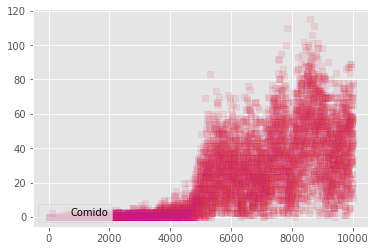

In [11]:
main(10000,100000,0.4,0.95)

In [6]:
main(10000,100000,0.25,0.85)